In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
%matplotlib inline

In [2]:
df = pd.read_csv('vaccination_tweets.csv')

In [3]:
df.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [4]:
# stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [5]:
def text_process(rev):
    txt = rev.lower()
#     txt = re.sub(r'\d+','',txt)
    txt = re.sub(r'@[^\s]+','',txt)
    txt = re.sub(r'\B#\S+','',txt)
    txt = re.sub(r"http\S+","",txt)
#     txt = re.sub(r'^https?:\/\/.*[\r\n]*', '', txt, flags=re.MULTILINE)
    txt = ' '.join(re.findall(r'\w+',txt))
    txt = re.sub(r'\b[a-zA-Z]\b','',txt)
    txt = re.sub(r'\s+',' ',txt,flags=re.I)
    txt = word_tokenize(txt)
    new_txt = []
    for word in txt:
        new_txt.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    txt = [word for word in new_txt if word not in stopwords.words('english')]
    return ' '.join(txt)

In [6]:
df['text'] = df['text'].apply(text_process)

In [7]:
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [8]:
sid = SIA()
df['sentiments'] = df['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
df['positive_sentiments'] = df['sentiments'].apply(lambda x: x['pos']+1*(10**-6))
df['neutral_sentiments'] = df['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
df['negative_sentiments'] = df['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

df.drop('sentiments',axis=1,inplace=True)

In [9]:
df['number_of_words'] = df['text'].apply(lambda x: len(x.split(' ')))
df['mean_word_length'] = df['text'].apply(lambda x: round(np.mean(len([len(w) for w in x.split(' ')]))),2)

In [10]:
plt.rc('figure',figsize=(18,12))
sns.set_style('darkgrid')

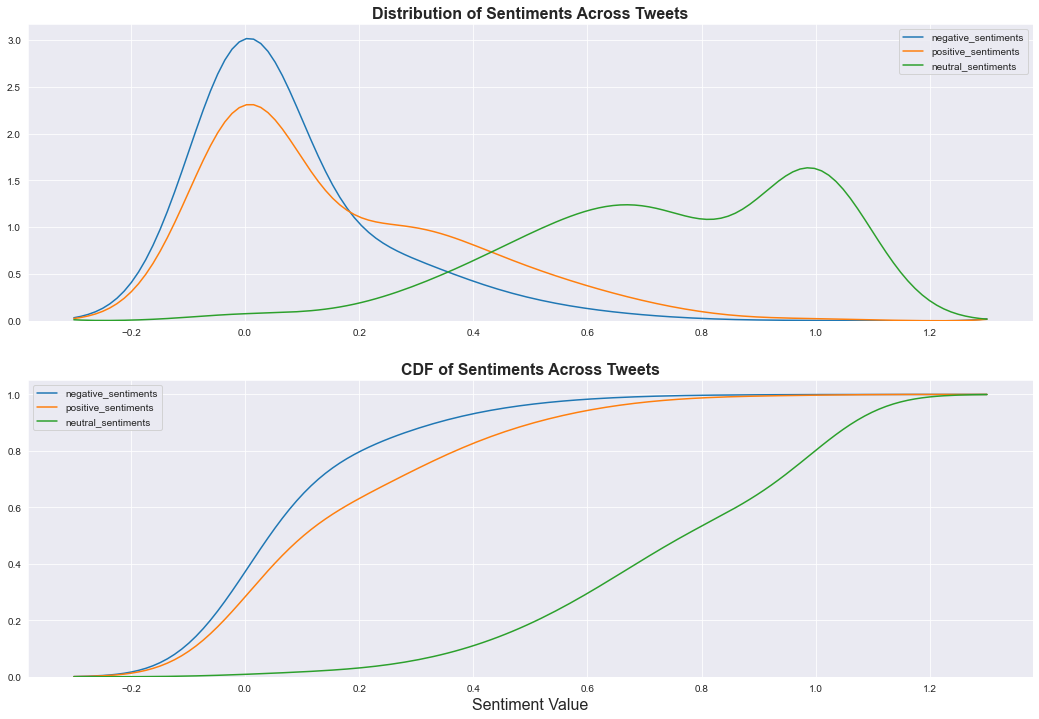

In [11]:
plt.subplot(2,1,1)
plt.title('Distribution of Sentiments Across Tweets',fontweight='bold',fontsize=16)
sns.kdeplot(df['negative_sentiments'],bw=0.1)
sns.kdeplot(df['positive_sentiments'],bw=0.1)
sns.kdeplot(df['neutral_sentiments'],bw=0.1)
plt.xlabel('')
plt.subplot(2,1,2)
plt.title('CDF of Sentiments Across Tweets',fontweight='bold',fontsize=16)
sns.kdeplot(df['negative_sentiments'],bw=0.1,cumulative=True)
sns.kdeplot(df['positive_sentiments'],bw=0.1,cumulative=True)
sns.kdeplot(df['neutral_sentiments'],bw=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=16)
plt.show()

In [12]:
df = df.sort_values(by='date')
dft = df.copy()
dft['date'] = pd.to_datetime(df['date']).dt.date

dft['year'] = pd.DatetimeIndex(dft['date']).year
dft['month'] = pd.DatetimeIndex(dft['date']).month
dft['day'] = pd.DatetimeIndex(dft['date']).day
dft['day_of_year'] = pd.DatetimeIndex(dft['date']).dayofyear
dft['quarter'] = pd.DatetimeIndex(dft['date']).quarter
dft['season'] = dft['month']%12 // 3 + 1

In [13]:
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [14]:
parts = []
parts.append(df.loc[:round(len(df)/3,0)-1])
parts.append(df.loc[round(len(df)/3,0):2*int(round(len(df)/3,0))-1])
parts.append(df.loc[2*int(round(len(df)/3,0)):3*int(round(len(df)/3,0))])

In [15]:
neg_part_means = []
neg_part_std = []
pos_part_means = []
pos_part_std = []
for part in parts:
    neg_part_means.append(part['negative_sentiments'].mean())
    neg_part_std.append(part['negative_sentiments'].std())
    pos_part_means.append(part['positive_sentiments'].mean())
    pos_part_std.append(part['positive_sentiments'].std())

In [16]:
res = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,
                   'Positive Sentiment Std':pos_part_std,'negative Sentiment Std':neg_part_std},index=[f'Part_{i}' for i in range (1,4)])
res

Positive Sentiment Mean  Negative Sentiment Mean  \
Part_1                 0.154200                 0.064222   
Part_2                 0.171509                 0.088041   
Part_3                 0.165100                 0.090334   

        Positive Sentiment Std  negative Sentiment Std  
Part_1                0.213261                0.140953  
Part_2                0.223078                0.157655  
Part_3                0.211313                0.161530

In [17]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

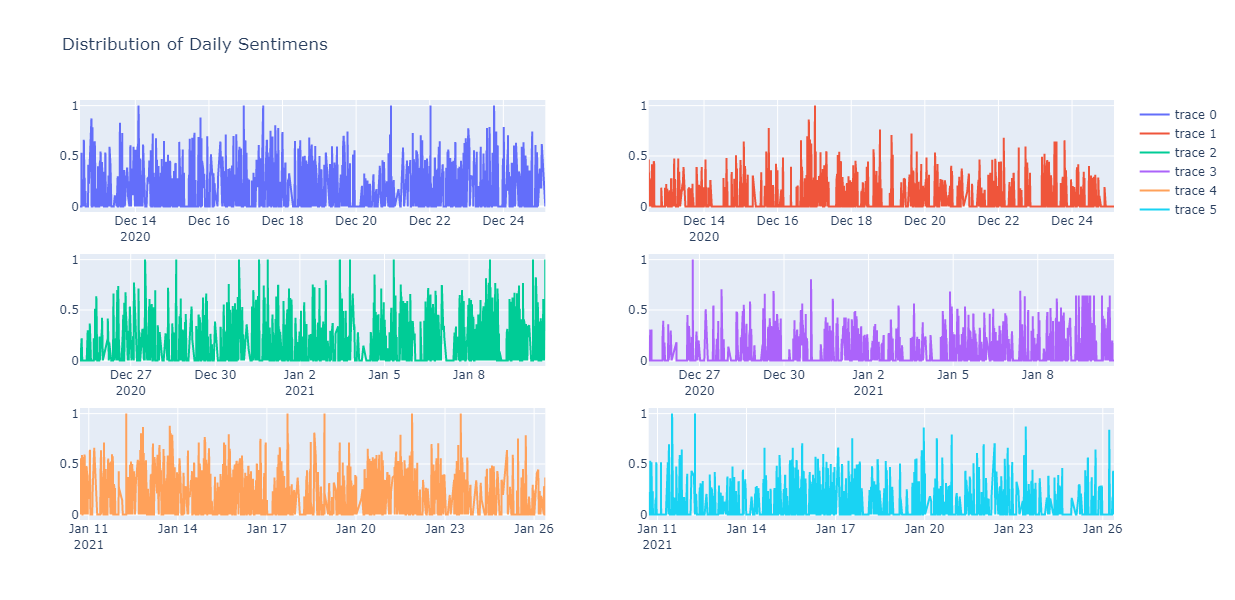

In [18]:
fig = make_subplots(3,2,)

for idx,part in enumerate(parts):
    fig.add_trace(go.Scatter(x=part['date'],y=part['positive_sentiments']),row=idx+1,col=1)
    fig.add_trace(go.Scatter(x=part['date'],y=part['negative_sentiments']),row=idx+1,col=2)

fig.update_layout(height=600,width=900,title_text='Distribution of Daily Sentimens')
    
fig.show()

In [19]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
b_date_mean = dft.groupby('date').mean().reset_index()

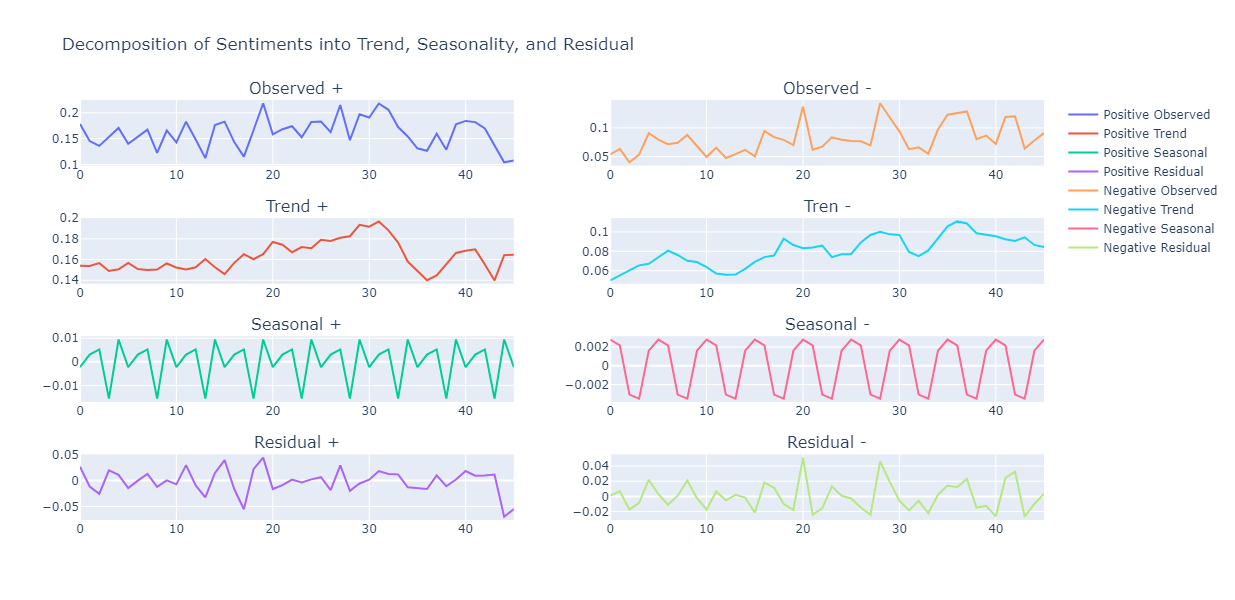

In [21]:
label = ['Positive','Negative']
fig = make_subplots(4,2,subplot_titles=('Observed +','Observed -','Trend +','Tren -',
                                        'Seasonal +','Seasonal -','Residual +','Residual -'))

for i,column in enumerate(['positive_sentiments','negative_sentiments']):
    res = seasonal_decompose(b_date_mean[column],period=5,model='additive',extrapolate_trend='freq')
    
    fig.add_trace(go.Scatter(x=np.arange(0,len(res.observed)),y=res.observed,name=f'{label[i]} Observed'),row=1,col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(0,len(res.trend)),y=res.trend,name=f'{label[i]} Trend'),row=2,col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(0,len(res.seasonal)),y=res.seasonal,name=f'{label[i]} Seasonal'),row=3,col=i+1)
    fig.add_trace(go.Scatter(x=np.arange(0,len(res.resid)),y=res.resid,name=f'{label[i]} Residual'),row=4,col=i+1)

fig.update_layout(height=600,width=900,title_text='Decomposition of Sentiments into Trend, Seasonality, and Residual')

fig.show()

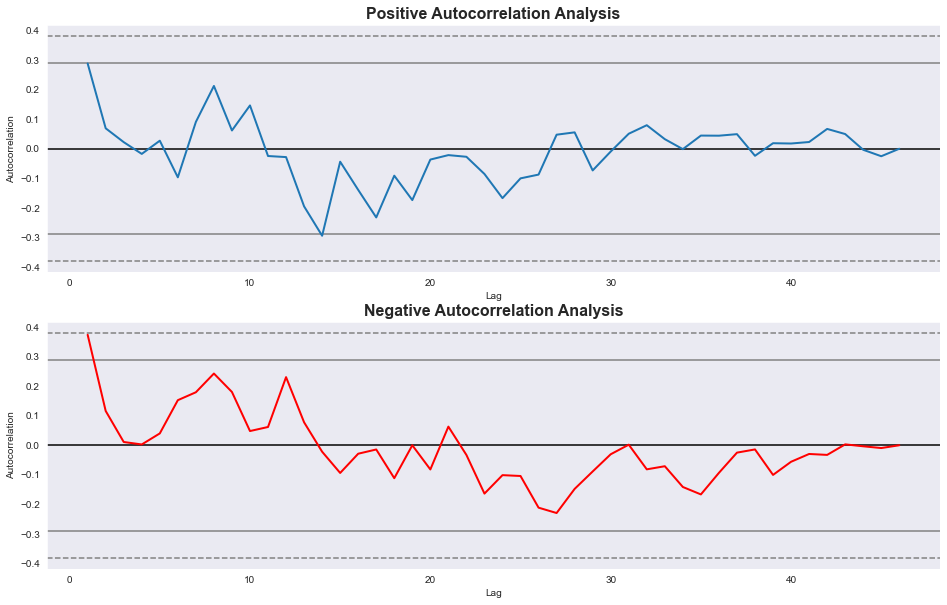

In [22]:
fig, ax = plt.subplots(2,1,figsize=(16,10))

ax[0].set_title('Positive Autocorrelation Analysis',fontweight='bold',fontsize=16)
autocorrelation_plot(b_date_mean['positive_sentiments'],ax=ax[0],lw=2)
ax[1].set_title('Negative Autocorrelation Analysis',fontweight='bold',fontsize=16)
autocorrelation_plot(b_date_mean['negative_sentiments'],ax=ax[1],color='red',lw=2)

plt.show()

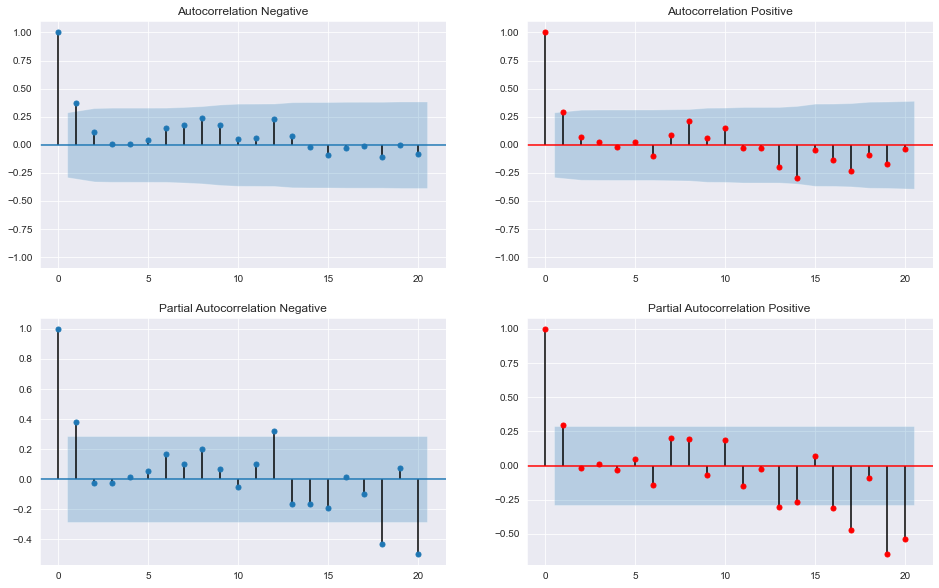

In [23]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow,ncol,figsize=(16,10))
i = 0
j = 0
while i < nrow:
    while j < ncol:
        ax[i,j].set_ylim(-1.1,1.1)
        j = j + 1
    i = i + 1

plot_acf(b_date_mean['negative_sentiments'],lags=20,ax=ax[0,0],title='Autocorrelation Negative')
plot_pacf(b_date_mean['negative_sentiments'],lags=20,ax=ax[1,0],title='Partial Autocorrelation Negative')
plot_acf(b_date_mean['positive_sentiments'],lags=20,ax=ax[0,1],title='Autocorrelation Positive',color='red')
plot_pacf(b_date_mean['positive_sentiments'],lags=20,ax=ax[1,1],title='Partial Autocorrelation Positive',color='red')

plt.show()

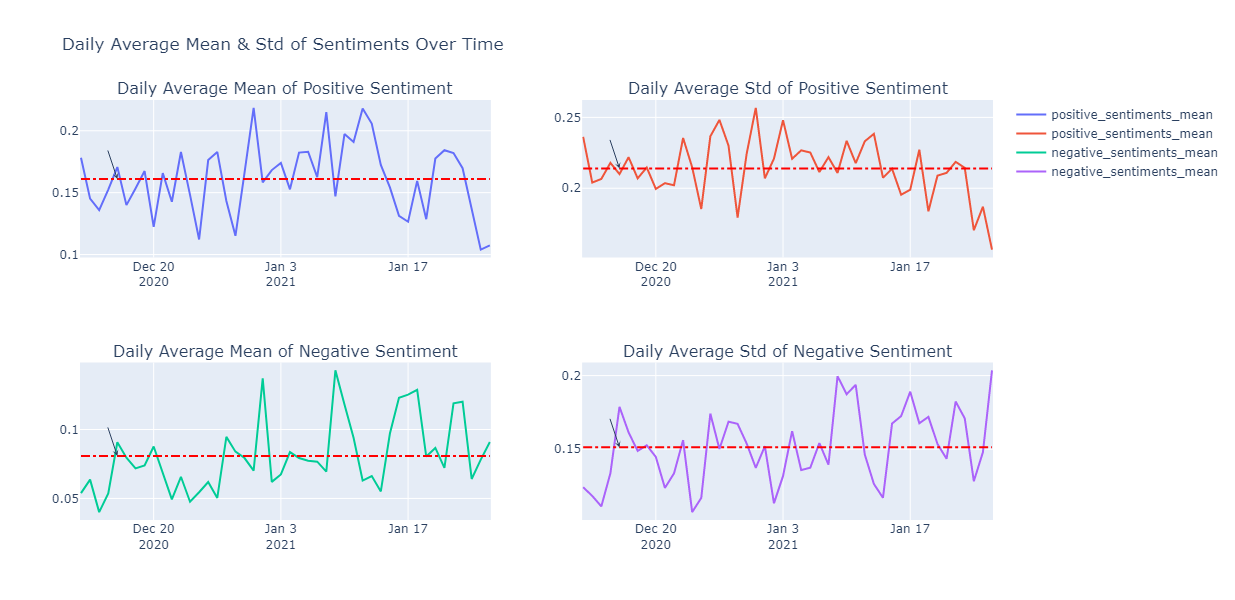

In [24]:
b_date_mean = dft.groupby(by='date').mean().reset_index()
b_date_std = dft.groupby(by='date').std().reset_index()

fig = make_subplots(2,2,subplot_titles=['Daily Average Mean of Positive Sentiment','Daily Average Std of Positive Sentiment',
                                        'Daily Average Mean of Negative Sentiment','Daily Average Std of Negative Sentiment'])

label = ['mean','std']
count = 0
for i,col in enumerate(['positive_sentiments','negative_sentiments']):
    for j,data in enumerate([b_date_mean,b_date_std]):
        fig.add_trace(go.Scatter(x=data['date'],y=data[col],name=col+'_mean'),row=i+1,col=j+1)

        fig.add_shape(type='line',
             x0=data['date'].values[0],y0=data[col].mean(),
             x1=data['date'].values[-1],y1=data[col].mean(),
             line = dict(color='Red',width=2,dash='dashdot'),xref='x' + str(count+1),yref='y' + str(count+1))

        fig.add_annotation(x=data['date'].values[4],y=data[col].mean(),
                  text=r"$\mu : {:.2f}$".format(data[col].mean()),
                  showarrow=True,
                  arrowhead=3,xref='x' + str(count+1),yref='y' + str(count+1))

        count = count + 1

fig.update_layout(height=600,width=1200,title_text='Daily Average Mean & Std of Sentiments Over Time')

fig.show()

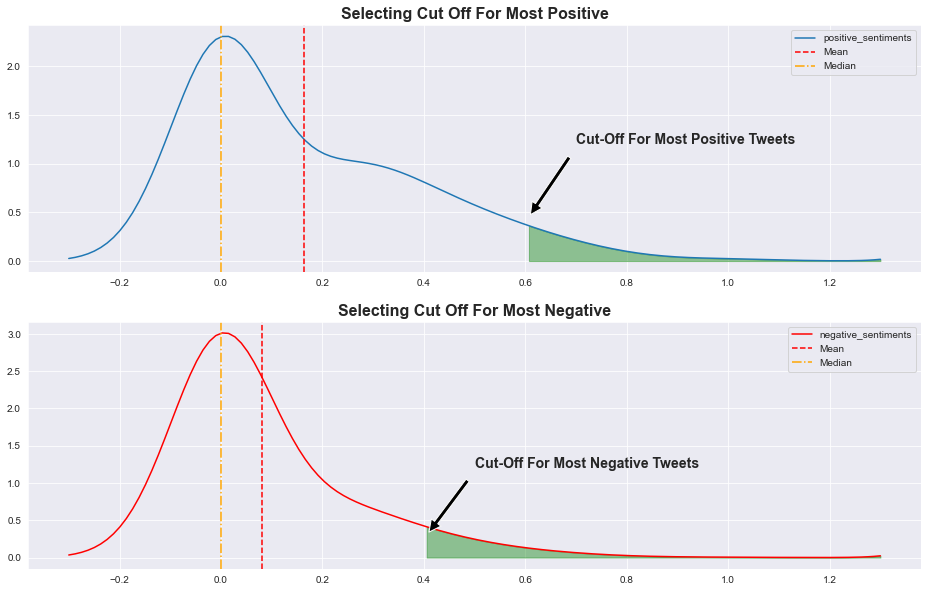

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,10))
sns.kdeplot(df['positive_sentiments'],bw=0.1,ax=ax1)
ax1.set_title('Selecting Cut Off For Most Positive',fontweight='bold',fontsize=16)
pos_kde_x, pos_kde_y = ax1.lines[0].get_data()
ax1.fill_between(pos_kde_x,pos_kde_y,where=(pos_kde_x>0.6),interpolate=True,color='green',alpha=0.4)
ax1.annotate('Cut-Off For Most Positive Tweets', xy=(0.6,0.4),xytext=(0.7,1.2),arrowprops=dict(facecolor='black',shrink=0.1),fontsize=14,fontweight='bold')
ax1.axvline(df['positive_sentiments'].mean(),color='red',ls='--',label='Mean')
ax1.axvline(df['positive_sentiments'].median(),color='orange',ls='-.',label='Median')
ax1.legend()
sns.kdeplot(df['negative_sentiments'],bw=0.1,ax=ax2,color='red')
ax2.set_title('Selecting Cut Off For Most Negative',fontweight='bold',fontsize=16)
neg_kde_x, neg_kde_y = ax2.lines[0].get_data()
ax2.fill_between(neg_kde_x,neg_kde_y,where=(neg_kde_x>0.4),interpolate=True,color='green',alpha=0.4)
ax2.annotate('Cut-Off For Most Negative Tweets', xy=(0.4,0.25),xytext=(0.5,1.2),arrowprops=dict(facecolor='black',shrink=0.1),fontsize=14,fontweight='bold')
ax2.axvline(df['negative_sentiments'].mean(),color='red',ls='--',label='Mean')
ax2.axvline(df['negative_sentiments'].median(),color='orange',ls='-.',label='Median')
ax2.legend()
plt.show()

In [31]:
most_positive = df[df['positive_sentiments'].between(0.6,1)]
most_negative = df[df['negative_sentiments'].between(0.4,1)]

In [27]:
from wordcloud import WordCloud, STOPWORDS

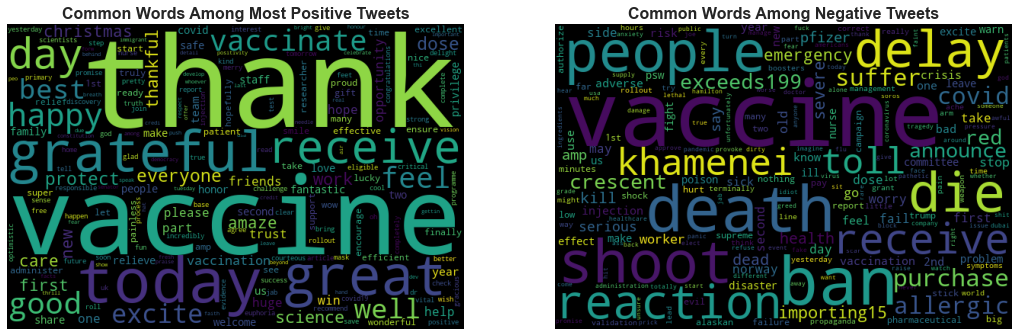

In [32]:
most_positive_text = ' '.join(most_positive['text'])
most_negative_text = ' '.join(most_negative['text'])

pwc= WordCloud(width=600,height=400,collocations=False).generate(most_positive_text)
nwc = WordCloud(width=600,height=400,collocations=False).generate(most_negative_text)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')
plt.show()

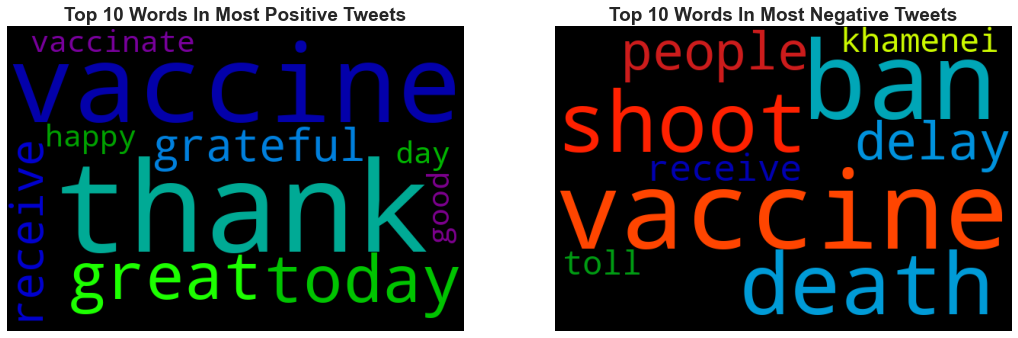

In [34]:
pos_dict = dict()
for word in most_positive_text.split():
    w = word.strip()
    if w in STOPWORDS:
        continue
    else:
        pos_dict[w] = pos_dict.get(w,0)+1
pos_dict = {k: v for k, v in sorted(pos_dict.items(), key=lambda item: item[1],reverse=True)}

neg_dict = dict()
for word in most_negative_text.split():
    w = word.strip()
    if w in STOPWORDS:
        continue
    else:
        neg_dict[w] = neg_dict.get(w,0)+1
neg_dict = {k: v for k, v in sorted(neg_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(pos_dict.keys())[:10]
top_10_neg = list(neg_dict.keys())[:10]

plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral').generate(' '.join(top_10_pos))
plt.title('Top 10 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral').generate(' '.join(top_10_neg))
plt.title('Top 10 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()